In [1]:
#setup

import numpy as np # workign with arrays
from numpy import genfromtxt
import matplotlib.pyplot as plt # making figures
from scipy.interpolate import CubicSpline # predicting ages using cubicspline model
import pandas as pd # dataframe manipulation

Note: there was some error in the table in Gradstein 2012 where two ages in the Cambrian were not chronological (Paibian and Guzhangian). I added to the older stage its uncertainty of about 2 Ma. This does not skew anything upstream. 

In [7]:
#read in age models tie points from csv files, files in same directory

#from GTS 2004 to 2012
gts_04_12 = pd.read_csv('gts_04_12.csv', sep= ',', header = 0, encoding='utf-8') 

# if the GTS04 age is the same as GTS2012 fill in GTS04 with GTS2012value
gts_04_12['GTS2004'] = gts_04_12['GTS2004'].fillna(gts_04_12['GTS2012']) 

gts_04_12

,Period,Stage,GTS2004,GTS2012,Uncertainty (95% CI)
0,Quaternary,TOP,0.0000,0.0000,NaN
1,NaN,Holocene,0.0115,0.0118,–
2,NaN,Tarantian,0.1260,0.1260,–
3,NaN,Ionian,0.7810,0.7810,–
4,NaN,Calabrian,1.8060,1.8060,–
...,...,...,...,...,...
97,NaN,Age 4,514.0000,514.0000,~2.0
98,NaN,Age 3,521.0000,521.0000,~2.0
99,NaN,Age 2,529.0000,529.0000,~2.0
100,NaN,Fortunian,542.0000,541.0000,1


In [15]:
# same for GTS 2012 to 2020
gts_12_20  = pd.read_csv('gts_12_20.csv', sep= ',', header = 0, encoding='utf-8') # no need to fill this one

In [158]:
def recalibrate(ages, data, filename): # data is an np.array, must be structured as a single column with dates to be converted

    min_date  = np.min(data)
    max_date = np.max(data)
    
    tie_points = ages[(ages['GTS2004'] > min_date) & (ages['GTS2004'] < max_date)]
    
    print("The tie points being used are:\n", tie_points)

    # Fit a cubic spline, # if you really want you can use a different model from scipy.interpolate
    spline = CubicSpline(tie_points['GTS2004'], tie_points['GTS2012'], bc_type='natural')
    
    # Apply transformation to the data
    converted = spline(data) 

    converted = pd.Series(converted)
    
    # concatenate transformed data with original data 
    result = pd.DataFrame({
        'Old GTS2004': data,
        'New GTS2012': converted.round(2)
    })

    # Plot the recalibrated data points
    plt.figure(figsize=(8, 5))

    plt.scatter(data, converted, color='red', label="Converted Points")

    # Add 1:1 reference line
    plt.plot([min(data), max(data)], [min(data), max(data)], 'k--', label='1:1 Line')
    
    #plot GTS 2004 (x) and GTS 2012 (y) tie points
    for x, y in zip(tie_points['GTS2004'], tie_points['GTS2012']):
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.8)
        plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.8)
        
    # Plot the age model curve
    plt.plot(data, converted, label="Recalibrated Age Model", color="blue")
    
    plt.xlabel("Gradstein 2004 (Ma)") #change this if you are converting from 2012 to 2020
    plt.ylabel("Gradstein 2012 (Ma)")
    plt.title("Recalibrated Age Model Using Cubic Spline")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
  
    result.to_csv(filename) # save dataframe as comma delimited so an open in other programs
    print(f"DataFrame saved to '{filename}'") 

    return None #result.head(5)
    

Example Usage. Upload dates for your datapoints as single column csv file.

Data from [Joachimski et al. (2009)](https://doi.org/10.1016/j.epsl.2009.05.028) and are the ages of conodont element oxygen isotope ratios in the Devonian Period

In [166]:
# import example data as np array, Joachimski et al (date) conodont apatite ages which were 

dates2change = genfromtxt('sampledates_in_gts2004.csv' , delimiter = ",", encoding="utf8") 

print(dates2change[:5])

[359.14 359.38 359.49 359.69 359.78]


Pass to the recalibrate function   
1.  The age model you want to convert from: GTS 2004 (gts_04_12) or GTS2012 (gts_12_20)  
2.  Your data
3.  A file name you want to save to as a string

The tie points being used are:
       Period        Stage  GTS2004  GTS2012 Uncertainty (95% CI)
68       NaN  Tournaisian    359.2    358.9                  0.4
69  Devonian    Famennian    374.5    372.2                  1.6
70       NaN     Frasnian    385.3    382.7                    1
71       NaN     Givetian    391.8    387.7                  0.8
72       NaN     Eifelian    397.5    393.3                  1.2
73       NaN       Emsian    407.0    407.6                  2.6
74       NaN      Pragian    411.2    410.8                  2.8
75       NaN   Lochkovian    416.0    419.2                  3.2
76  Silurian      Pridoli    418.7    423.0                  2.3


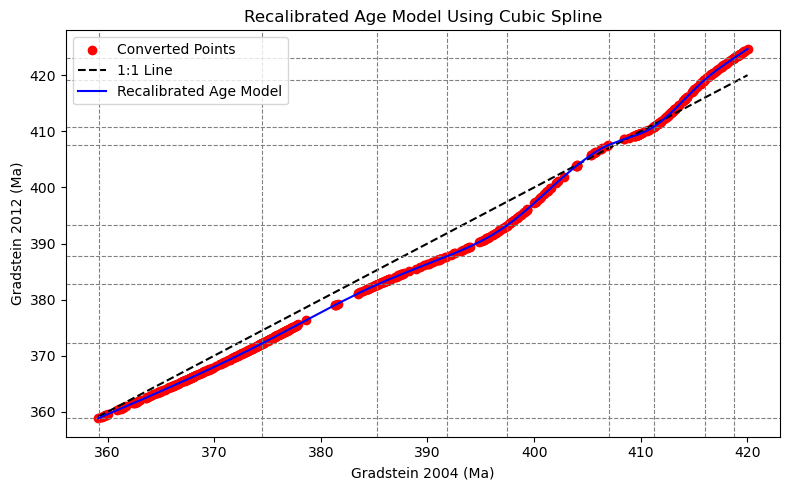

DataFrame saved to 'recalibrated_dates'


In [156]:
recalibrate(gts_04_12, dates2change, "recalibrated_dates")